<a href="https://colab.research.google.com/github/ahforoughi/Knowledge-based-recomender-system/blob/main/KB_recomender_system_movies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Knowledge-based recommender system on IMDB 
IMDb is the most popular movie website and it combines movie plot description, Metastore ratings, critic and user ratings and reviews, release dates, and many more aspects.

The website is well know for storing almost every movie that has ever been released (the oldest is from 1874 - "Passage de Venus") or just planned to be released (newest movie is from 2027 - "Avatar 5"). 

The movies dataset includes 85,855 movies with attributes such as movie description, average rating, number of votes, genre, etc.

The ratings dataset includes 85,855 rating details from demographic perspective.

The names dataset includes 297,705 cast members with personal attributes such as birth details, death details, height, spouses, children, etc.

The title principals dataset includes 835,513 cast members roles in movies with attributes such as IMDb title id, IMDb name id, order of importance in the movie, role, and characters played.

We just used first 1000 rows for simplicity, and during preperation we drop some unuseful coloumns and keep some useful that we can search on them. 


First we import some library  

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tests as t
from ast import literal_eval

Here is reading from full data set.

In [8]:
data_path = "/content/IMDb movies.csv"
! unzip "/content/drive/MyDrive/Colab Notebooks/IMDb movies.csv.zip"
data = pd.read_csv(data_path)
data.head()

Archive:  /content/drive/MyDrive/Colab Notebooks/IMDb movies.csv.zip
replace IMDb movies.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: no


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,writer,production_company,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000009,Miss Jerry,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,Alexander Black,Alexander Black,Alexander Black Photoplays,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,NaN,NaN,NaN,NaN,1.0,2.0
1,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,None,Charles Tait,Charles Tait,J. and N. Tait,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,589,$ 2250,NaN,NaN,NaN,7.0,7.0
2,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,"Urban Gad, Gebhard Schätzler-Perasini",Fotorama,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.8,188,NaN,NaN,NaN,NaN,5.0,2.0
3,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,Victorien Sardou,Helen Gardner Picture Players,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...,5.2,446,$ 45000,NaN,NaN,NaN,25.0,3.0
4,tt0002130,L'Inferno,L'Inferno,1911,1911-03-06,"Adventure, Drama, Fantasy",68,Italy,Italian,"Francesco Bertolini, Adolfo Padovan",Dante Alighieri,Milano Film,"Salvatore Papa, Arturo Pirovano, Giuseppe de L...",Loosely adapted from Dante's Divine Comedy and...,7.0,2237,NaN,NaN,NaN,NaN,31.0,14.0


We shrink our dataset to first 1000 rows and drop some unuseful columns and keep some that we can search on them.    

In [9]:
print("data shape before shrink", data.shape)
data = data.iloc[:1000, : ]
data = data[['title', 'year', 'genre', 'duration', 'country', 'avg_vote', 'votes']]
print("data shape after shrink", data.shape)

data shape before shrink (85855, 22)
data shape after shrink (1000, 7)


In [10]:
data.dtypes
data.head()

,title,year,genre,duration,country,avg_vote,votes
0,Miss Jerry,1894,Romance,45,USA,5.9,154
1,The Story of the Kelly Gang,1906,"Biography, Crime, Drama",70,Australia,6.1,589
2,Den sorte drøm,1911,Drama,53,"Germany, Denmark",5.8,188
3,Cleopatra,1912,"Drama, History",100,USA,5.2,446
4,L'Inferno,1911,"Adventure, Drama, Fantasy",68,Italy,7.0,2237


We invert all data in year column to integer data type so we can use arithmatic function for these data.  

In [11]:
def convert_int(x):
    try:
        return int(x)
    except: 
        return 0
data['year'] = data['year'].apply(convert_int)
data.dtypes

title        object
year          int64
genre        object
duration      int64
country      object
avg_vote    float64
votes         int64
dtype: object

We don't want NaN values for non of the columns so we have to fill them with some data. I decided to fill them with null string value. 

In [12]:
#Convert all NaN into stringified empty lists
data['genre'] = data['genre'].fillna('')

As we can see the genres feature is in the format which is like a object.

Then we need to​​ explode​​ the column `genre`. You can say if any movie has more than one genre,​​ multiple movies copies will be created in which every movie will have one of the genres. Such as, if a movie named as "The Story of the Kelly Gang" which have multiple genre as: Biography, Crime and Drama.  

it will be explode into three rows.

To do this we split them by comma at first then we explode a row to number of genres that row has.    

In [13]:
data['genre'] = data['genre'].str.split(',')
data = data.explode('genre')

Here we check that any of columns don't have any null value. 

In [14]:
# check null values for each column
columns = list(data.columns)
for i in columns:
    print (f"null values for {i} =", data[i].isnull().sum())

null values for title = 0
null values for year = 0
null values for genre = 0
null values for duration = 0
null values for country = 0
null values for avg_vote = 0
null values for votes = 0


Building the simple recommender is fairly straightforward. The steps are as follows:
1.   Choose a metric (or score) to rate the movies on
2.   Decide on the prerequisites for the movie to be featured on the chart
3.   Calculate the score for every movie that satisfies the conditions
4.   Output the list of movies in decreasing order of their scores

The metric is the numeric quantity based on which you rank movies. A movie is considered to be better than another movie if it has a higher metric score than the other movie. It is very important that you have a robust and reliable metric to build your chart upon to ensure a good quality of recommendations.

One of the simplest metrics that can be used is the movie rating. Therefore, a movie rated 9 by 100,000 users will be placed below a movie rated 9.5 by 100 users. 

It is also a well-known fact that as the number of voters increase, the rating of a movie normalizes and it approaches a value that is reflective of the movie’s quality and popularity with the general populace. To put it another way, movies with very few ratings are not very reliable. A movie rated 10/10 by five users doesn’t necessarily mean that it’s a good movie.

Fortunately, you do not have to brainstorm a mathematical formula for the metric. You can use IMDB’s weighted rating formula as your metric. Mathematically, it can be represented as follows:


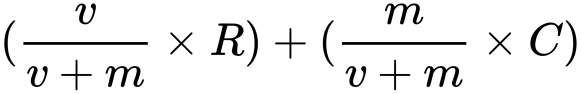

The following apply:
*    v is the number of votes garnered by the movie
*    m is the minimum number of votes required for the movie to be in the chart (the prerequisite)
*    R is the mean rating of the movie
*    C is the mean rating of all the movies in the dataset



`weighted_rating` is a function for evaluting the score for each row, it takes as its input a row as `x`, `C` as mean of all records in the table. 

In [15]:
 def weighted_rating(x, C, m):
     v = x['votes']
     R = x['avg_vote']
     ## Compute the weighted score
     return (v/(v+m) * R) + (m/(m+v) * C)

`search_in_data` will take parameters to search on desired parameters. The data that you have has information on the duration, genres, and timelines, but it isn’t currently in a form that is directly usable. Your data needs to be wrangled before it can be put to use to build this recommender.

For some part of search we can use pre-built python operators. To check highest and lowest time and something like this for year. 

For your recommender, use the number of votes garnered by the 80th percentile movie as your value for `m`. In other words, for a movie to be considered in the rankings, it must have garnered more votes than at least 80% of the movies present in your dataset. Additionally, the number of votes garnered by the 80th percentile movie is used in the weighted formula described previously to come up with the value for the scores. we will pass this parameter to `weighted_rating` as m.  

We calculate mean of the result table after search by `mean`. 

We just consider the records with number of votes higher than a threshold that we defined. 

Then we apply `weighted_rating` function on final results as described in step before and save the return value in a seprated column as `score`. and then return sorted result on score parameter, in descending form. 


In [16]:
 def search_in_data(genre, low_time, high_time, low_year, high_year, movies, percent=0.8):

    result = movies[(movies['genre']==genre) &
                    (movies['duration']>=low_time) &
                    (movies['duration']<=high_time) &
                    (movies['year']>=low_year) & 
                    (movies['year']<=high_year)
    ]

    vote_ave = result['avg_vote'].mean()
    vote_thresh = result['votes'].quantile(percent)

    f_results = result.copy().loc[(result['votes'] > vote_thresh)]

    f_results['score'] = f_results.apply(weighted_rating, C=vote_ave, m=vote_thresh, axis=1)
    f_results = f_results.sort_values('score', ascending=False) 

    return f_results



We can take input from user. I just defined them hard coded to test the code. 

You can see that the movies that it outputs satisfy all the conditions you passed in as input. Since you applied IMDB’s metric, you can also observe that your movies are very highly rated and popular at the same time.

In [17]:
# Ask for input
# genre = input("Enter your prefered genre: ")
# low_time = int(input("Enter your prefered low_time: "))
# high_time = int(input("Enter your prefered high_time: "))
# low_year = int(input("Enter your prefered low_year: "))
# high_year = int(input("Enter your prefered high_year: "))


# test data
genre = 'Crime'
low_time = 40
high_time = 90
low_year = 1920
high_year = 1930

KBS = search_in_data(genre, low_time, high_time, low_year, high_year, data)#.head()
KBS



,title,year,genre,duration,country,avg_vote,votes,score
632,I dannati dell'oceano,1928,Crime,76,USA,7.5,3860,7.240160
610,Le notti di Chicago,1927,Crime,80,USA,7.6,2545,7.217102
499,Il pensionante,1927,Crime,68,UK,7.3,10024,7.204358
707,Ricatto,1929,Crime,85,UK,7.0,9412,6.933694
702,Asfalto,1929,Crime,90,Germany,7.4,1328,6.931817
455,Il trio infernale,1925,Crime,86,USA,7.2,1613,6.865428
851,Carcere,1930,Crime,87,USA,7.1,1849,6.831092
266,Il castello di Vogelod,1921,Crime,75,Germany,6.2,1391,6.307738


## Refrences 


1.   Towards Knowledge-Based Recommender Dialog System, Qibin Chen, Junyang Lin, Yichang Zhang, Ming Ding, Yukuo Cen, Hongxia Yang, Jie Tang
2.   An Overview of Knowledge-Based Recommender Systems 
3.   An Introduction to Knowledge-based Recommender System, Shwetank Sonal